Using device: cpu
开始训练LeNet-5...
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.302557
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.727138
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.331140
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.238729
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.245630
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.115867
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.224630
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.162707
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.112930
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.149135

Test set: Average loss: 0.0860, Accuracy: 9731/10000 (97.31%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.051133
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.057097
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.080767
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.024804
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.144932
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.050759
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.109614
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.028877
Train Epoch: 2 

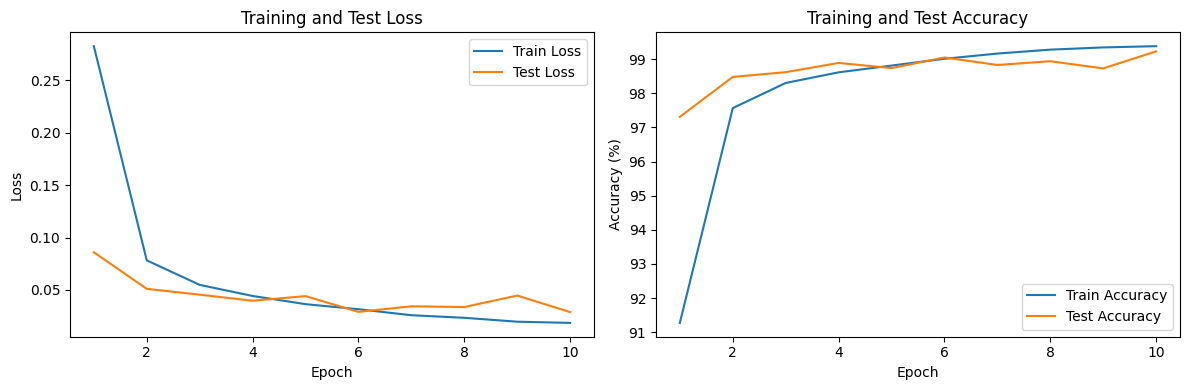

模型已保存为 'lenet5_mnist.pth'


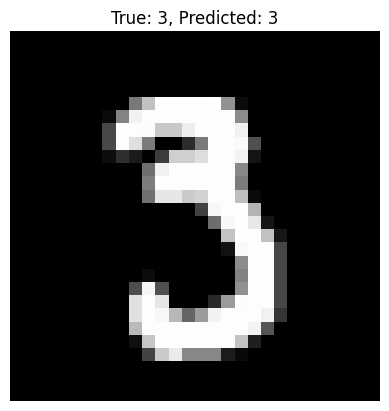

真实标签: 3, 预测标签: 3


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# 定义LeNet-5模型
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        # 卷积层部分
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, padding=2)  # 输入通道1，输出通道6
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)           # 输入通道6，输出通道16
        # 全连接层部分
        self.fc1 = nn.Linear(16 * 5 * 5, 120)                  # 16*5*5 -> 120
        self.fc2 = nn.Linear(120, 84)                          # 120 -> 84
        self.fc3 = nn.Linear(84, 10)                           # 84 -> 10 (输出类别)
        
    def forward(self, x):
        # 第一层：卷积 -> ReLU -> 平均池化
        x = F.relu(self.conv1(x))
        x = F.avg_pool2d(x, kernel_size=2, stride=2)
        
        # 第二层：卷积 -> ReLU -> 平均池化
        x = F.relu(self.conv2(x))
        x = F.avg_pool2d(x, kernel_size=2, stride=2)
        
        # 展平特征图
        x = x.view(-1, 16 * 5 * 5)
        
        # 全连接层
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# 数据预处理
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST数据集的均值和标准差
])

# 加载数据集
train_dataset = datasets.MNIST(root='./python_mnist', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./python_mnist', train=False, download=True, transform=transform)

# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# 初始化模型、损失函数和优化器
model = LeNet5().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练函数
def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
        
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
    
    accuracy = 100. * correct / total
    avg_loss = train_loss / len(train_loader)
    return avg_loss, accuracy

# 测试函数
def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
    
    test_loss /= len(test_loader)
    accuracy = 100. * correct / total
    
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{total} ({accuracy:.2f}%)\n')
    return test_loss, accuracy

# 训练过程
epochs = 10
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

print("开始训练LeNet-5...")
for epoch in range(1, epochs + 1):
    train_loss, train_acc = train(model, device, train_loader, optimizer, criterion, epoch)
    test_loss, test_acc = test(model, device, test_loader, criterion)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

print("训练完成！")

# 绘制训练曲线
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Test Loss')

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training and Test Accuracy')

plt.tight_layout()
plt.show()

# 保存模型
torch.save(model.state_dict(), 'lenet5_mnist.pth')
print("模型已保存为 'lenet5_mnist.pth'")

# 在单个图像上测试模型
def predict_single_image(model, device, test_dataset):
    model.eval()
    # 随机选择一个测试图像
    idx = torch.randint(0, len(test_dataset), (1,)).item()
    image, label = test_dataset[idx]
    
    # 添加batch维度并预测
    image = image.unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(image)
        prediction = output.argmax(dim=1).item()
    
    # 显示图像和预测结果
    plt.imshow(image.cpu().squeeze(), cmap='gray')
    plt.title(f'True: {label}, Predicted: {prediction}')
    plt.axis('off')
    plt.show()
    
    return label, prediction

# 测试单个图像
true_label, pred_label = predict_single_image(model, device, test_dataset)
print(f'真实标签: {true_label}, 预测标签: {pred_label}')

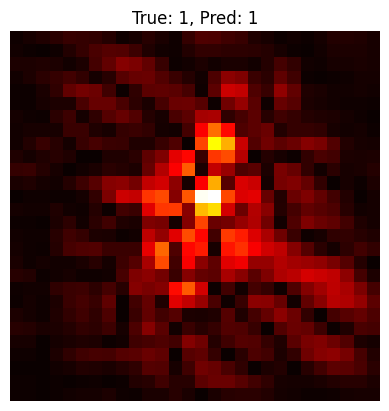

In [9]:

model.load_state_dict(torch.load('lenet5_mnist.pth', map_location='cpu'))
model.eval()

# 计算saliency
img, label = datasets.MNIST('./python_mnist', train=False, download=True, 
                           transform=transforms.ToTensor())[2]
img.requires_grad = True
output = model(img.unsqueeze(0))
output[0, output.argmax()].backward()
saliency = img.grad.data.abs().squeeze()

# 显示
plt.imshow(saliency, cmap='hot')
plt.title(f'True: {label}, Pred: {output.argmax().item()}')
plt.axis('off')
plt.show()